In [15]:
import sys
sys.path.append("..")

from ris_evaluation.evaluator import Evaluator

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from bertopic import BERTopic
from umap import UMAP

In [16]:
documents_df = pd.read_csv('../datasets/data/BBC_News/documents.csv')
documents_df = documents_df

documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

In [17]:
umap = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=False, random_state=0)
bert_model = BERTopic(language="english", calculate_probabilities=True, nr_topics=6, umap_model=umap)
topics, probs = bert_model.fit_transform(documents)

In [18]:
bert_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,387,-1_government_system_work_game,"[government, system, work, game, firm, company...",[world population live thing mind television s...
1,0,561,0_film_good_music_game,"[film, good, music, game, award, show, phone, ...",[door open big gadget fair thousand technology...
2,1,400,1_election_party_labour_government,"[election, party, labour, government, tory, pl...",[hit back claim tory leader act attack show la...
3,2,392,2_rise_economy_growth_market,"[rise, economy, growth, market, company, sale,...",[german economy rebound economy big country sh...
4,3,391,3_win_play_player_game,"[win, play, player, game, match, club, final, ...",[manager admit loss explain bottom half table ...
5,4,94,4_charge_test_drug_company,"[charge, test, drug, company, fraud, iaaf, fir...",[duo clear dope case sprinter clear dope offen...


In [19]:
results_df = pd.DataFrame()
results_df['document'] = documents
results_df['y_true'] = labels
results_df['y_pred'] = topics
results_df['y_pred_highest_proba'] = np.max(probs, axis=1)

results_df

,document,y_true,y_pred,y_pred_highest_proba
0,hit shelf combine medium player phone gaming g...,tech,0,0.459403
1,bid hope join host apply host tournament aim r...,sport,-1,0.688152
2,lord wrong detainee straw straw attack decisio...,politics,1,1.000000
3,leak answer minister explain budget detail pri...,politics,1,0.730469
4,delight manager pay tribute goal striker beat ...,sport,3,0.613128
...,...,...,...,...
2220,rock clean steer clear bad language front awar...,entertainment,0,0.610834
2221,comedy meet sequel meet parent top week movie ...,entertainment,0,1.000000
2222,join rare group actress nominate oscar star fo...,entertainment,0,0.723314
2223,police chief back move chief back introduction...,politics,1,0.548743


In [20]:
def get_words_for_topics(topics):
    words_by_topics = {}
    for idx, topic in enumerate(topics):
        words = documents_df.iloc[idx]['document'].split()

        if topic not in words_by_topics:
            words_by_topics[topic] = {}

        for word in words:
            if word not in words_by_topics[topic]:
                words_by_topics[topic][word] = 0

            words_by_topics[topic][word] += 1

    return words_by_topics

In [21]:
relevant_results_df = results_df[results_df['y_pred'] != -1]

model_output = {
    "topics": [item for item in bert_model.get_topic_info()["Representation"]],
    "topic-document-matrix": probs.transpose(),
    "topic-word-matrix": bert_model.c_tf_idf_,
    "test-topic-document-matrix": probs.transpose()
}
evaluator = Evaluator(model_output)

words_by_extracted_topics = get_words_for_topics(relevant_results_df['y_pred'].tolist())
words_by_class = get_words_for_topics(relevant_results_df['y_true'].tolist())

In [22]:
coherence = evaluator.compute_coherence()
diversity = evaluator.compute_diversity()
supervised_correlation = evaluator.compute_supervised_correlation(words_by_extracted_topics, words_by_class)

metrics_df = pd.DataFrame()

for coherence_type, coherence_value in coherence.items():
    metrics_df[f'Coherence ({coherence_type})'] = [coherence_value]
metrics_df['Diversity'] = [diversity]
metrics_df['Supervised correlation'] = [supervised_correlation]
metrics_df

,Coherence (c_v),Coherence (c_uci),Coherence (c_npmi),Coherence (u_mass),Diversity,Supervised correlation
0,0.48018,0.098477,0.03439,-2.424933,0.85,0.722048


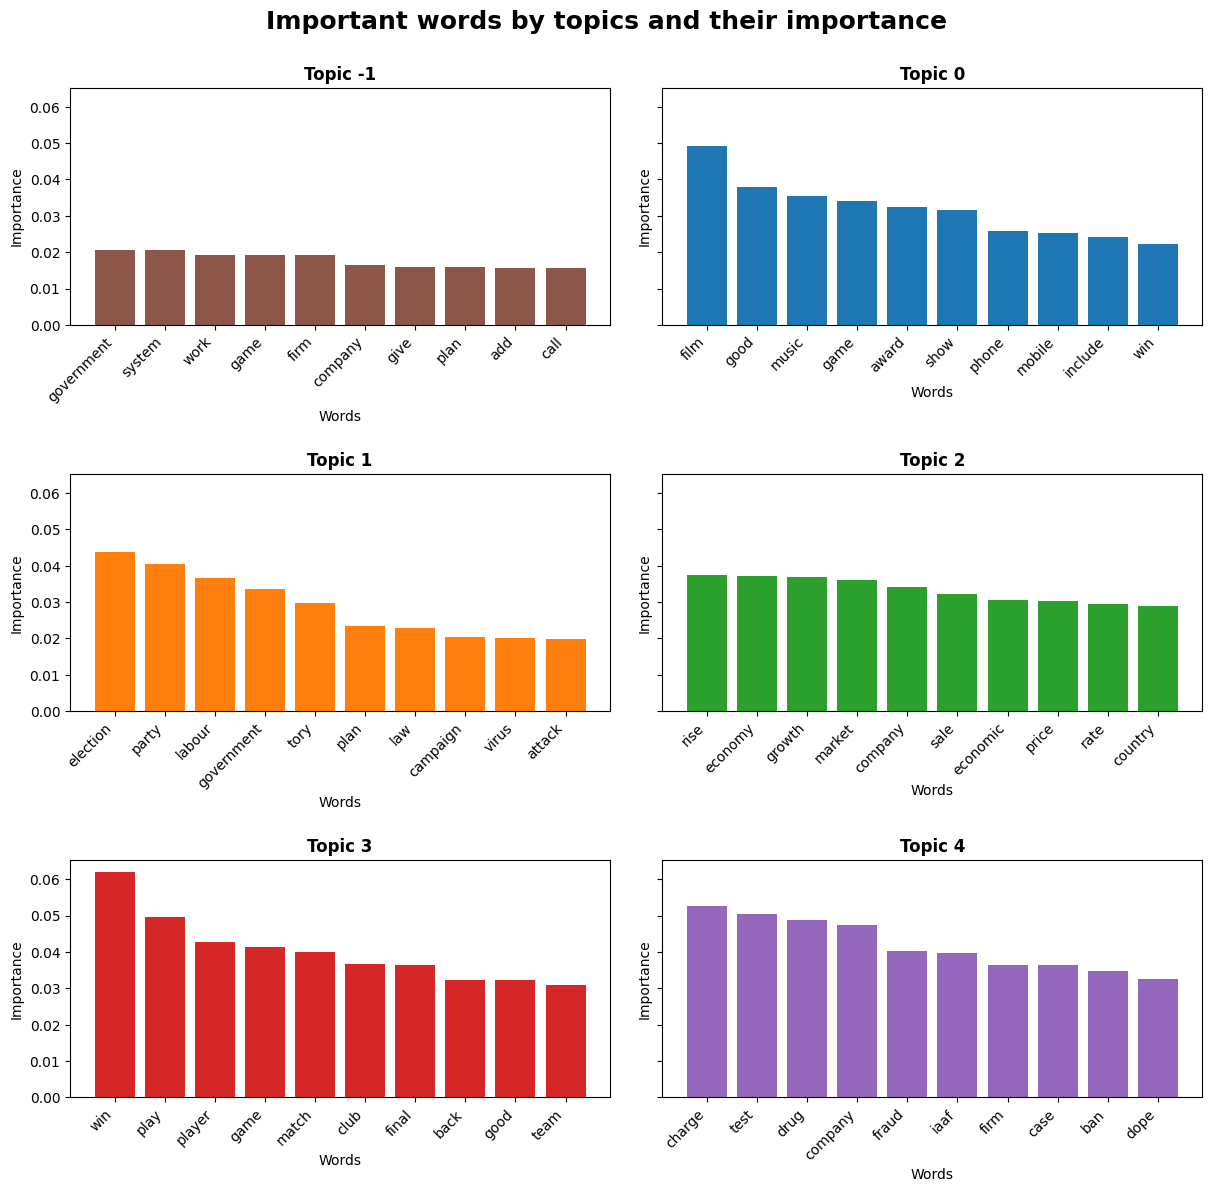

In [23]:
no_top_words = 10
x, y = 0, 0
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

# Plotting the important words by topics and their importance
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey=True)
fig.suptitle('Important words by topics and their importance', fontsize=18, fontweight='bold')

for topic_idx, topic in enumerate(bert_model.get_topic_info()['Topic']):
    topic_idx = topic_idx - 1

    features = [feature[0] for feature in bert_model.get_topics()[topic_idx]]
    importance_for_features = [feature[1] for feature in bert_model.get_topics()[topic_idx]]

    ax = axes[x, y]
    ax.set_title(f'Topic {topic_idx}', fontsize=12, fontweight='bold')
    ax.bar(features, importance_for_features, color=colors[topic_idx])
    ax.set_xlabel('Words')
    ax.set_ylabel('Importance')
    ax.xaxis.set_ticks(features)
    ax.set_xticklabels(features, rotation=45, ha='right')

    if y == 1:
        x += 1
        y = 0
    else:
        y += 1

fig.tight_layout(pad=2.0, rect=[-0.02, -0.02, 1.02, 1])
fig.savefig('../figures/bertopic/important_words_by_topics.png')

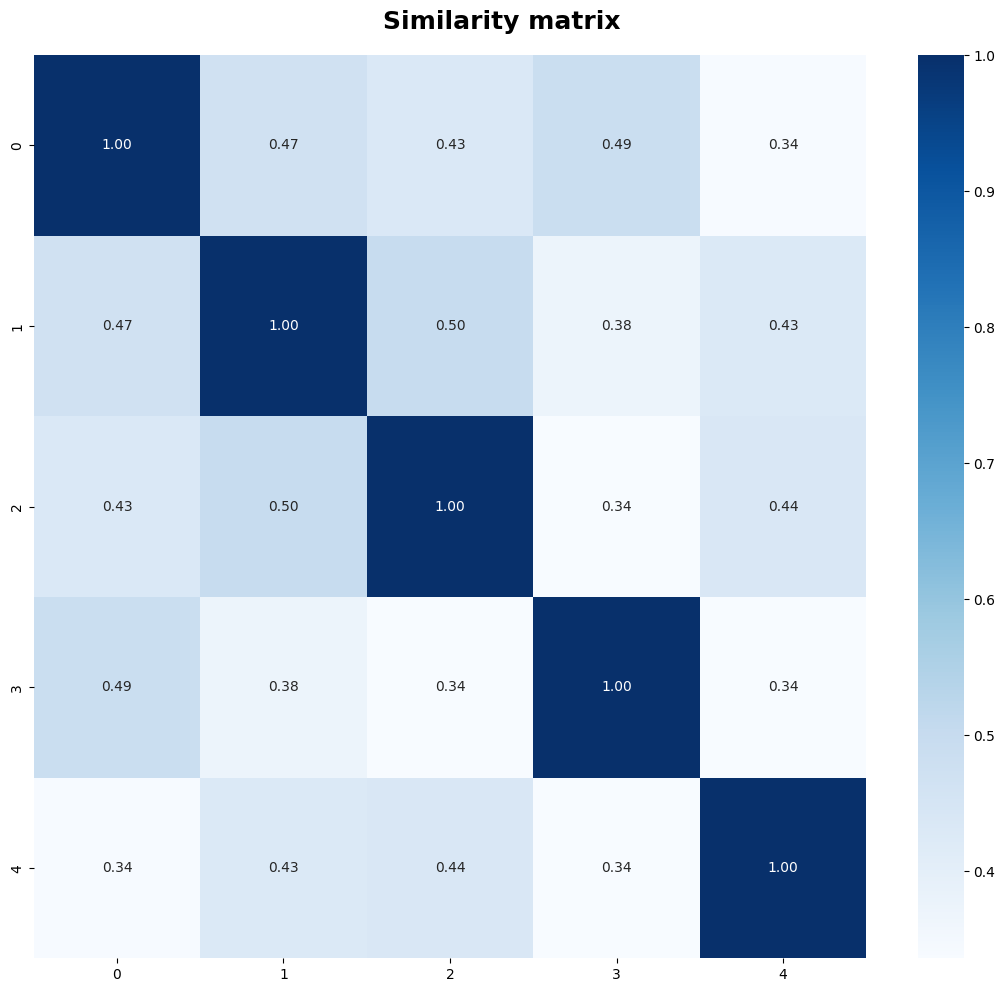

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

distance_matrix = cosine_similarity(bert_model.c_tf_idf_)
distance_matrix_labels = bert_model.get_topic_info()['Topic'].tolist()

# Removing the first row and column
distance_matrix = distance_matrix[1:, 1:]
distance_matrix_labels = distance_matrix_labels[1:]

# Plotting the distance matrix
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('Similarity matrix', fontsize=18, fontweight='bold')

sns.heatmap(distance_matrix, ax=ax, cmap='Blues', xticklabels=distance_matrix_labels, yticklabels=distance_matrix_labels, annot=True, fmt='.2f')

fig.tight_layout(pad=2.0, rect=[-0.02, -0.02, 1.1, 1.02])
fig.savefig('../figures/bertopic/similarity_matrix.png')